In [21]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


In [1]:
from src.utils import astype_to_category, convert_category_into_integer
from src.model.decision_tree import decision_tree
from src.model.logistic_regression import logit
from src.model.svm import svc

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as ds
import torchvision.transforms as transforms

import lightning as L
from lightning.pytorch.trainer import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

import warnings

14046

<Axes: xlabel='Churn', ylabel='DroppedCalls'>

,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating
count,1.404600e+04,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000,14046.000000
mean,3.192837e+06,40.320288,298.313612,42.177132,0.492597,2.606578,0.548505,-23.507547,-2.154443,3.202784,2.579973,16.973473,1.001160,0.156998,54.211277,14.463591,4.246013,53.894753,37.188566,5.805938,0.008472,0.569714,18.838032,1.537448,1.595828,1.417557,420.369144,33.687598,23.492881,0.024064,0.011391,0.044853,4.697209,0.047985
std,1.145395e+05,16.902368,254.384236,18.588147,1.053840,4.820760,1.775994,114.305210,2.368437,3.743365,6.724621,22.541945,3.160354,0.514653,75.305492,18.625635,8.110261,52.345245,45.413630,8.245641,0.350106,1.335175,9.569556,0.854190,1.056756,0.752356,255.049424,21.797432,24.500607,0.166181,0.111999,0.238922,3.057689,0.370663
min,3.000026e+06,0.520000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1038.000000,-9.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,1.000000,1.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.093723e+06,30.630000,106.000000,30.000000,0.000000,0.000000,0.000000,-66.000000,-3.200000,0.300000,0.000000,3.300000,0.000000,0.000000,3.200000,1.700000,0.000000,15.700000,7.000000,1.300000,0.000000,0.000000,11.000000,1.000000,1.000000,1.000000,238.000000,22.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,3.188434e+06,36.450000,231.000000,40.000000,0.000000,0.000000,0.000000,-16.000000,-1.100000,2.000000,0.700000,10.300000,0.000000,0.000000,24.550000,8.000000,1.000000,41.000000,21.700000,3.300000,0.000000,0.000000,17.000000,1.000000,1.000000,1.000000,363.000000,38.000000,24.000000,0.000000,0.000000,0.000000,6.000000,0.000000
75%,3.292553e+06,50.630000,417.000000,50.000000,0.500000,3.000000,0.200000,19.000000,-0.400000,4.700000,2.300000,22.700000,0.700000,0.000000,75.200000,20.000000,5.000000,76.300000,50.300000,7.700000,0.000000,0.700000,25.000000,2.000000,2.000000,2.000000,571.000000,50.000000,46.000000,0.000000,0.000000,0.000000,7.000000,0.000000
max,3.399942e+06,99.700000,1199.000000,115.000000,20.300000,19.000000,34.800000,886.000000,-0.100000,19.700000,175.300000,597.300000,150.000000,21.300000,950.500000,239.700000,113.300000,557.700000,662.300000,179.000000,26.300000,24.300000,60.000000,12.000000,16.000000,11.000000,1713.000000,98.000000,99.000000,3.000000,3.000000,11.000000,9.000000,12.000000


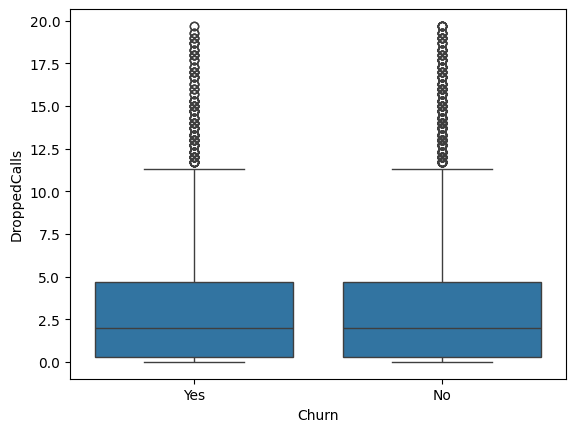

In [45]:
## 경고 무시
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
## train, test 데이터 불러오기
origin_train = pd.read_csv('../data/train.csv', encoding='cp949').dropna()
origin_test = pd.read_csv('../data/test.csv', encoding='cp949')
drop_columns = ['ActiveSubs', 'HandsetRefurbished', 'HandsetWebCapable', 'ServiceArea', 'ChildrenInHH', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'NonUSTravel', 'MadeCallToRetentionTeam', 'OwnsMotorcycle', 'CreditRating', 'MaritalStatus', 'Occupation', 'PrizmCode']
origin_train = origin_train.drop(columns=drop_columns)
origin_test = origin_test.drop(columns=drop_columns)
origin_train = origin_train.query("MonthlyRevenue < 100")
origin_train = origin_train.query("MonthlyMinutes < 1200")
origin_train = origin_train.query("OverageMinutes < 20")
origin_train = origin_train.query("-10 < PercChangeRevenues < 0")
# origin_train = origin_train.query("-10 < PercChangeRevenues < 0")
display(len(origin_train))
display(sns.boxplot(origin_train, y='DroppedCalls', x='Churn'))
display(origin_train.describe())
train = origin_train
test = origin_test
objects = []
train.dtypes
for idx in range(len(train.columns)):
    if train.dtypes[idx] == object:
        objects.append(train.columns[idx])
# print(objects)
# DroppedCalls
# BlockedCalls
# UnansweredCalls
# CustomerCareCalls
# ThreewayCalls
# ReceivedCalls
# OutboundCalls
# InboundCalls
# PeakCallsInOut
# OffPeakCallsInOut
# DroppedBlockedCalls
# CallForwardingCalls
# CallWaitingCalls
# MonthsInService
# UniqueSubs
# ActiveSubs
# Handsets
# HandsetModels
# AgeHH1
# AgeHH2
# RetentionCalls
# RetentionOffersAccepted
# ReferralsMadeBySubscriber
# AdjustmentsToCreditRating

In [46]:
## 범주형 변수 인코딩하기
train, _ = convert_category_into_integer(train, objects)
test, _ = convert_category_into_integer(test, objects)

## 데이터 종류가 object인 칼럼을 카테고리화 하기
train = astype_to_category(train)
test = astype_to_category(test)
## 타겟 변수 정의
target = 'Churn'
# display(train.columns.unique())
## train 데이터 분할하기
seed = 0
train, valid = train_test_split(train, test_size=0.4, random_state=seed)
# print(len(train), len(valid), len(test))
## 특성 스케일링
compare_columns = train.columns.difference(objects)
standard_scaler = StandardScaler()
train.loc[:, compare_columns] = standard_scaler.fit_transform(train.loc[:, compare_columns])
valid.loc[:, compare_columns] = standard_scaler.transform(valid.loc[:, compare_columns])
test.loc[:, compare_columns] = standard_scaler.transform(test.loc[:, compare_columns])

train = pd.DataFrame(train, columns=origin_train.columns)
# df_train.corr()

logit(target, train, valid, seed, compare_columns, sample_size=300)
decision_tree(target, train, test, seed, sample_size=300)
svc(target, train, valid, seed, sample_size=300)

logistic:	0.7259298807617014
decision_tree:	0.65735
svc linear  0.657
svc poly  0.710
svc rbf  0.717
svc sigmoid  0.677
